In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('merged_promoter_activity_final.csv')
print(len(df))
df.head()

#### Function to Calculate Promoter Variance

In [ ]:
def calculate_promoter_variance(row, name):
    # Filter columns matching the provided name (e.g., '.counts')
    values = row.filter(like=name).values
    
    # Check if there are enough values to calculate variance
    if len(values) > 1:
        return np.var(values, ddof=1)  # Variance calculation with degrees of freedom = 1
    else:
        return np.nan  # Return NaN if variance cannot be computed

### Sequencing Depth Normalization and Log2 Transformtaion
Size Factor calculation for each sample

In [ ]:
# Step 1: Identify columns that end with '.counts'
counts_columns = [col for col in df.columns if col.endswith('.counts')]

# Step 2: Calculate size factor for each counts column
size_factors = {col: df[col].sum() / 10**6 for col in counts_columns}

In [ ]:
def preprocessing(df, size_factors):
    df = df.copy()

    # Step 1: Create lognorm columns and store their target positions
    counts_columns = df.filter(like='.counts').columns
    sample_names = [col.split(".")[0] for col in counts_columns]

    for col in counts_columns:
        sample_name = col.split(".")[0]

        # Compute CPM and log-normalized values
        norm_counts_col = f"{sample_name}.norm_counts"
        lognorm_col = f"{sample_name}.lognorm"
        df[norm_counts_col] = df[col] / size_factors[col]
        df[lognorm_col] = np.log2(df[norm_counts_col] + 1)

    # Step 2: Compute gene-level sums and relative activity
    for sample_name in sample_names:
        lognorm_col = f"{sample_name}.lognorm"
        gene_col = f"{sample_name}.gene"
        rel_col = f"{sample_name}.rel"

        gene_sum = df.groupby('geneId')[lognorm_col].transform('sum')
        df[gene_col] = gene_sum
        df[rel_col] = df[lognorm_col] / df[gene_col]

    # Step 3: Reorder columns
    first_9_columns = list(df.columns[:9])
    sample_columns = []

    for sample_name in sample_names:
        sample_group = [
            f"{sample_name}.counts",
            f"{sample_name}.norm_counts",
            f"{sample_name}.lognorm",
            f"{sample_name}.gene",
            f"{sample_name}.rel"
        ]
        # Only include columns that actually exist (in case any are missing)
        sample_group = [col for col in sample_group if col in df.columns]
        sample_columns.extend(sample_group)

    # Add any remaining columns (e.g., .class or metadata)
    known_columns = set(first_9_columns + sample_columns)
    remaining_columns = [col for col in df.columns if col not in known_columns]

    # Final reordered DataFrame
    df = df[first_9_columns + sample_columns + remaining_columns]

    return df

In [ ]:
df = preprocessing(df,size_factors)

### Function to Obtain Promoter sequences

In [ ]:
from pyfaidx import Fasta
# Load genome
genome = Fasta("GCF_003668045.1_CriGri-PICR_genomic.fna")

In [ ]:
def get_upstream(seqname, tss, strand, upstream=200):

    if pd.isna(seqname) or pd.isna(tss) or pd.isna(strand):
        return None  # Handle missing values
    
    tss = int(tss)  # Ensure TSS is an integer
    
    if strand == "+":
        start, end = max(0, tss - upstream - 1), tss - 1
    else:
        start, end = tss, tss + upstream
    seq = genome[seqname][start:end].seq
    return seq if strand == "+" else seq[::-1].translate(str.maketrans("ACGTacgt", "TGCAtgca"))

### Function to obtain condition specific averaged dataframe

In [ ]:
def gen_col_name_df(df, metdf , column_name):
    """
    Process log-normalized expression values based on grouping in metdf.
    
    Parameters:
        metdf (pd.DataFrame): Metadata containing sample grouping information.
        df (pd.DataFrame): Expression data with .lognorm columns.
        column_name (str): The column in metdf used for grouping samples.
    
    Returns:
        pd.DataFrame: Processed DataFrame with averaged lognorm values and relative means.
    """
    # Step 1: Create dictionary mapping each category to its samples
    media_dict = metdf.groupby(column_name)["Sample_ID"].apply(list).to_dict()
    
    # Step 2: Create new DataFrame with metadata columns
    metadata_columns = [
        "promoterId", "geneId", "seqnames", "start", "strand", "internalPromoter", "promoterPosition", "seqaccession", "txId"
    ]
    coldf = df[metadata_columns].copy()
    
    # Step 3: Compute averaged lognorm values for each media type
    for media, samples in media_dict.items():
        lognorm_columns = [f"{sample}.lognorm" for sample in samples if f"{sample}.lognorm" in df.columns]
        if lognorm_columns:
            coldf[f"{media}.lognorm"] = df[lognorm_columns].mean(axis=1)
    
    # Step 4: Process lognorm columns to compute relative means
    lognorm_columns = [col for col in coldf.columns if col.endswith('.lognorm')]
    epsilon = 1e-6  # Small value to avoid division by zero
    coldf[lognorm_columns] = coldf[lognorm_columns].replace({0: epsilon, np.nan: epsilon})
    
    new_columns = {}
    for lognorm_col in lognorm_columns:
        sample_name = lognorm_col.split(".")[0]
        gene_sum = coldf.groupby('geneId')[lognorm_col].transform('sum')
        coldf[f"{sample_name}.gene"] = gene_sum
        
        if f"{sample_name}.gene" in coldf.columns:
            coldf[f"{sample_name}.rel_mean"] = coldf[lognorm_col] / coldf[f"{sample_name}.gene"]
            new_columns[f"{sample_name}.rel_mean"] = f"{sample_name}.gene"
    
    # Step 5: Reorder columns for better organization
    first_9_columns = coldf.columns[:9]
    sample_names = [col.split(".")[0] for col in lognorm_columns]
    new_order = list(first_9_columns)
    for sample_name in sample_names:
        new_order.extend([f"{sample_name}.lognorm", f"{sample_name}.gene", f"{sample_name}.rel_mean"])
    
    return coldf[new_order]

In [ ]:
celldf = gen_col_name_df(df,metdf,'Cell')

### Function to classify all promoters (for each promoter)

In [ ]:
def classify_promoters(df):
    lognorm_columns = [col for col in df.columns if col.endswith('.lognorm')]
    
    for col in lognorm_columns:
        sample_name = col.split('.')[0]
        class_col = f"{sample_name}.class"
        rel_mean_col = f"{sample_name}.rel"
        
        # Compute max values per geneId
        max_values = df.groupby('geneId')[col].transform('max')
        
        # Step 1: Set everything to "Minor" by default
        df[class_col] = 'Minor'
        
        # Step 2: Assign "Major" to max values
        df.loc[df[col] == max_values, class_col] = 'Major'
        
        # Step 3: Override with "Inactive" where values are < 0.25
        df.loc[df[col] < 0.25, class_col] = 'Inactive'
        
        # Set .rel_mean to NaN where .class is Inactive
        if rel_mean_col in df.columns:
            df.loc[df[class_col] == 'Inactive', rel_mean_col] = np.nan
        
        # Insert class column next to rel_mean column
        if rel_mean_col in df.columns:
            rel_mean_index = df.columns.get_loc(rel_mean_col)
            df.insert(rel_mean_index + 1, class_col, df.pop(class_col))
    
    return df

In [ ]:
celldf = classify_promoters(celldf)

### Function to assign class based average of all samples

In [ ]:
def add_overall_class(df, threshold=0.25):
    # 1. Identify the .lognorm columns
    lognorm_cols = [col for col in df.columns if col.endswith(".lognorm")]

    # 2. Compute the mean lognorm value per row
    df["mean_lognorm"] = df[lognorm_cols].mean(axis=1)

    # 3. Assign "Inactive" where mean is below threshold
    df["overall_class"] = "Minor"  # default
    df.loc[df["mean_lognorm"] < threshold, "overall_class"] = "Inactive"

    # 4. For each geneId, find the row with the highest mean_lognorm
    major_idx = df[df["mean_lognorm"] >= threshold].groupby("geneId")["mean_lognorm"].idxmax()

    # 5. Mark those as "Major"
    df.loc[major_idx, "overall_class"] = "Major"

    return df


### Finding alternative promoters (against control celltype)

In [ ]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def get_samples_by_metadata(metdf, column, value):
    return metdf[metdf[column] == value]['Sample_ID'].tolist()

In [ ]:
def identify_alternative_promters(df_multi, metdf, meta_column, control_type, test_type):
    # Sample extraction
    control_samples = get_samples_by_metadata(metdf, meta_column, control_type)
    test_samples = get_samples_by_metadata(metdf, meta_column, test_type)

    # Column matching
    lognorm_control = [f"{s}.lognorm" for s in control_samples if f"{s}.lognorm" in df_multi.columns]
    lognorm_test = [f"{s}.lognorm" for s in test_samples if f"{s}.lognorm" in df_multi.columns]
    gene_control = [f"{s}.gene" for s in control_samples if f"{s}.gene" in df_multi.columns]
    gene_test = [f"{s}.gene" for s in test_samples if f"{s}.gene" in df_multi.columns]

    # Matrix extraction
    lognorm_control_data = df_multi[lognorm_control].values
    lognorm_test_data = df_multi[lognorm_test].values

    # Promoter fold change
    promoterFC = (lognorm_test_data.mean(axis=1) + 1e-6) / (lognorm_control_data.mean(axis=1) + 1e-6)

    # T-test with variance check
    pvals = np.full(df_multi.shape[0], np.nan)
    for i in range(df_multi.shape[0]):
        ctrl_vals = lognorm_control_data[i, :]
        test_vals = lognorm_test_data[i, :]
        if np.std(ctrl_vals) == 0 or np.std(test_vals) == 0:
            continue
        _, p = ttest_ind(test_vals, ctrl_vals, equal_var=False)
        pvals[i] = p

    # Multiple testing correction
    valid = ~np.isnan(pvals)
    adj_pvals = np.full_like(pvals, np.nan)
    adj_pvals[valid] = multipletests(pvals[valid], method='fdr_bh')[1]

    # Gene-level fold change
    gene_control_data = df_multi[gene_control].values
    gene_test_data = df_multi[gene_test].values
    geneFC = (gene_test_data.mean(axis=1) + 1e-6) / (gene_control_data.mean(axis=1) + 1e-6)

    # Build results DataFrame
    results = df_multi.copy()
    results['promoterFC'] = promoterFC
    results['geneFC'] = geneFC
    results['adj_pval'] = adj_pvals
    results['is_hit'] = (results['promoterFC'] > 1.8) & \
                        (results['geneFC'] < 1.3) & \
                        (results['adj_pval'] < 0.05)
    results['comparison'] = f"{test_type}_vs_{control_type}"

    return results


In [ ]:
control = 'K1'
celltypes = metdf['Cell'].unique()
all_results = []

for test in celltypes:
    if test == control:
        continue
    print(f"Comparing {test} to {control}...")
    result = identify_alternative_promters(df_multi, metdf, meta_column='Cell', control_type=control, test_type=test)
    result['celltype'] = test
    all_results.append(result)

# Combine all
combined_results = pd.concat(all_results, ignore_index=True)

Comparing K1 (GS) to K1...
Comparing DG44 to K1...
Comparing S to K1...
Comparing DXB11 to K1...


### Function to create promoter heatmap

In [ ]:
def make_promoter_heatmap(df_multi, metdf, sig_results_dedup,  column, column_type):
    # Step 1: Get promoter list in order
    promoter_list = sig_results_dedup['promoterId'].tolist()
    
    # Step 2: Extract all .lognorm columns
    lognorm_cols = [col for col in df_multi.columns if col.endswith(f'.{column_type}')]

    # Step 3: Map sample to cell type
    sample_to_cell = dict(zip(metdf['Sample_ID'], metdf[column]))

    # Step 4: Group samples by cell type (preserving order)
    celltype_order = metdf[column].drop_duplicates().tolist()
    celltype_to_samples = {
        cell: [f"{s}.{column_type}" for s in metdf[metdf[column] == cell]['Sample_ID'] if f"{s}.{column_type}" in lognorm_cols]
        for cell in celltype_order
    }

    # Step 5: Compute mean expression per promoter per cell type
    heatmap_data = []
    for promoter in promoter_list:
        row = []
        for cell in celltype_order:
            sample_cols = celltype_to_samples[cell]
            val = df_multi.loc[df_multi['promoterId'] == promoter, sample_cols].mean(axis=1).values
            row.append(val[0] if len(val) > 0 else np.nan)
        heatmap_data.append(row)

    heatmap_df = pd.DataFrame(heatmap_data, index=promoter_list, columns=celltype_order)

    # Step 6: Plot heatmap
    plt.figure(figsize=(6, 8))
    sns.heatmap(heatmap_df, cmap="Reds", cbar_kws={"label": "Mean Promoter Activity"})
    plt.xlabel("Cell Lineage")
    plt.ylabel("Cell line-Specific Promoters")
    plt.title("Cell Line Specific Promoter Activity")
    plt.tight_layout()
    plt.yticks([], [])
    plt.show()

# Usage



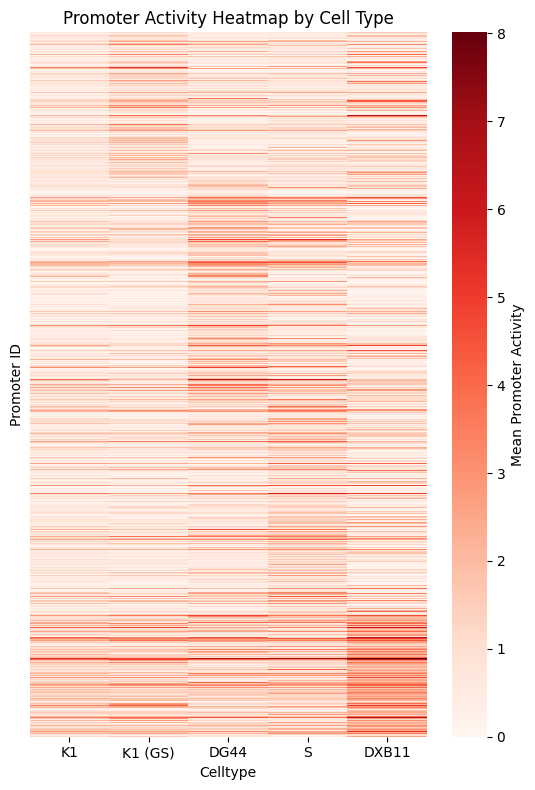

In [ ]:
make_promoter_heatmap(df_multi, metdf, sig_results_dedup, "Cell")

### Finding alternative promoters (taking a specific cell type against all other samples)

In [ ]:
def identify_alternative_promters_specific(df_multi, metdf, meta_column, test_type):
    # Sample extraction
    test_samples = get_samples_by_metadata(metdf, meta_column, test_type)
    control_samples = [s for s in metdf['Sample_ID'].tolist() if s not in test_samples]

    # Column matching
    lognorm_control = [f"{s}.lognorm" for s in control_samples if f"{s}.lognorm" in df_multi.columns]
    lognorm_test = [f"{s}.lognorm" for s in test_samples if f"{s}.lognorm" in df_multi.columns]
    gene_control = [f"{s}.gene" for s in control_samples if f"{s}.gene" in df_multi.columns]
    gene_test = [f"{s}.gene" for s in test_samples if f"{s}.gene" in df_multi.columns]

    # Matrix extraction
    lognorm_control_data = df_multi[lognorm_control].values
    lognorm_test_data = df_multi[lognorm_test].values

    # Promoter fold change
    promoterFC = (lognorm_test_data.mean(axis=1) + 1e-6) / (lognorm_control_data.mean(axis=1) + 1e-6)

    # T-test with variance check
    pvals = np.full(df_multi.shape[0], np.nan)
    for i in range(df_multi.shape[0]):
        ctrl_vals = lognorm_control_data[i, :]
        test_vals = lognorm_test_data[i, :]
        if np.std(ctrl_vals) == 0 or np.std(test_vals) == 0:
            continue
        _, p = ttest_ind(test_vals, ctrl_vals, equal_var=False)
        pvals[i] = p

    # Multiple testing correction
    valid = ~np.isnan(pvals)
    adj_pvals = np.full_like(pvals, np.nan)
    adj_pvals[valid] = multipletests(pvals[valid], method='fdr_bh')[1]

    # Gene-level fold change
    gene_control_data = df_multi[gene_control].values
    gene_test_data = df_multi[gene_test].values
    geneFC = (gene_test_data.mean(axis=1) + 1e-6) / (gene_control_data.mean(axis=1) + 1e-6)

    # Build results DataFrame
    results = df_multi.copy()
    results['promoterFC'] = promoterFC
    results['geneFC'] = geneFC
    results['adj_pval'] = adj_pvals
    results['is_hit'] = (results['promoterFC'] > 2) & \
                        (results['geneFC'] < 1.4) & \
                        (results['adj_pval'] < 0.05)
    results['comparison'] = f"{test_type}"

    return results


In [ ]:
celltypes = metdf['Cell'].unique()
all_results_specific = []

for test in celltypes:
    print(f"Comparing {test}")
    result_specific = identify_alternative_promters_specific(df_multi, metdf, meta_column='Cell', test_type=test)
    result_specific['celltype'] = test
    all_results_specific.append(result_specific)

# Combine all
combined_results_specific = pd.concat(all_results_specific, ignore_index=True)

Comparing K1
Comparing K1 (GS)
Comparing DG44
Comparing S
Comparing DXB11


### Function to parse GTF annotation files

In [ ]:
# Define GTF column names
gtf_columns = ["seqnames", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]

# Load GTF file into a DataFrame
gtf_df = pd.read_csv("GCF_003668045.1_CriGri-PICR_genomic.gtf", sep="\t", comment="#", header=None, names=gtf_columns)

In [ ]:
import re

def parse_attributes(attribute_string):
    attributes = {}
    for attr in attribute_string.strip().split(";"):
        attr = attr.strip()
        if attr:
            parts = attr.split(" ", 1)  # Split only on the first space
            if len(parts) == 2:
                key, value = parts
                attributes[key] = value.strip('"')  # Remove surrounding quotes
    return attributes

# Apply function to extract gene_id and transcript_id
gtf_df["attributes_dict"] = gtf_df["attribute"].apply(parse_attributes)

gtf_df["gene_id"] = gtf_df["attributes_dict"].apply(lambda x: x.get("gene_id", None))
gtf_df["transcript_id"] = gtf_df["attributes_dict"].apply(lambda x: x.get("transcript_id", None))

# Drop the temporary dictionary column
gtf_df.drop(columns=["attributes_dict"], inplace=True)

# To remove duplicate rows while ignoring the attribute column
# gtf_df = gtf_df.loc[~gtf_df.drop(columns=["attribute"]).duplicated(keep="first")]